# CSE 391 - ACCENT IDENTIFICATION 

## Let's first import the necessary libraries

In [157]:
%matplotlib inline
import os.path
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fftpack
from IPython.display import Audio
from scipy.io import wavfile
from skimage import util
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from pandas_ml import ConfusionMatrix

## Set all file location/name constants and load the data

In [158]:
RECORDINGS = 'recordings/'
DATA_FILE_NAME = 'speakers_all.csv'
FILE_EXTENSION = '.mp3'
speech_data = pd.read_csv(DATA_FILE_NAME).iloc[:, :-3]
speech_data.head(10)


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True
5,43.0,41.0,"port-au-prince, haiti",haitian,haitian,male,1167,haiti,True
6,21.0,21.0,"port-au-prince, haiti",haitian,haitian,male,1168,haiti,True
7,54.0,51.0,"port-au-prince, haiti",haitian,haitian,female,1169,haiti,True
8,18.0,16.0,"ouanaminthe, haiti",haitian,haitian,female,1866,haiti,True
9,73.0,5.0,"pepeekeo, hawai'i, usa",hawai'i,hawai'i,male,1675,usa,True


In [159]:
speech_data.shape

(2172, 9)

### The "file_missing" column specifies which speaker's dont have a corresponding audio file. Lets remove those rows and then remove the column all together.

In [160]:
# We get rid of the files that don't have a corresponding speech file
speech_data = speech_data[speech_data['file_missing?'] == False].iloc[:, :-1]
speech_data.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa
37,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,3,ivory coast
38,41.0,5.0,"accra, ghana",akan1,akan,male,979,ghana
39,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,4,kosovo
40,33.0,15.0,"tirana, albania",albanian2,albanian,male,5,albania
41,44.0,35.0,"tirana, albania",albanian3,albanian,male,458,albania


### As of now, there are too many languages to classify accurately. We pulled a UN country grouping by region and are going to map each country to that grouping. This way we can cut down the number of classes significantly

In [161]:
MAP_FILE = 'UNcountrygroupingz.csv'
map_data = pd.read_csv(MAP_FILE, names=['Country','Region'])
map_data.Country = map_data.Country.str.lower()
map_data.Region.value_counts()
#map_data[map_data['Region'] == 'Europe']

Asia               35
The Caribbean      28
European Union     27
Europe             27
Eastern Africa     19
Western Africa     17
Oceania            15
South America      14
Middle East        14
Middle Africa       9
Northern Africa     8
Central America     8
North America       5
Southern Africa     5
Region              1
Name: Region, dtype: int64

## After mapping, we can now plot how many of each category we have. As you can see, the data is very skewed (North America, Asia and EU have significantly more data than the rest.)

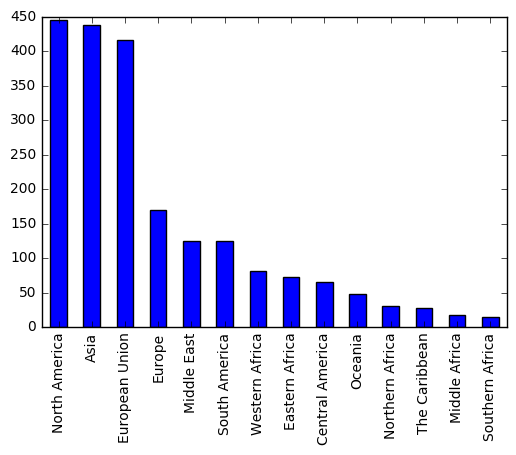

In [163]:
speech_data['region'] = speech_data['country'].map(map_data.set_index('Country')['Region'])
pd.value_counts(speech_data['region']).plot.bar()

### There are also a few countries that were not given in the UN classification. These represents a very small portion of the data so for now, let's just remove them.

In [164]:
speech_data.loc[speech_data.region.isnull() == True].country.value_counts()

bosnia and herzegovina            14
republic of georgia                6
federated states of micronesia     6
democratic republic of congo       5
myanmar                            4
ivory coast                        3
slovak republic                    3
curacao                            2
libya                              2
tibet                              2
northern mariana islands           2
solomon islands                    2
us virgin islands                  1
timor-leste                        1
the bahamas                        1
israel (occupied territory)        1
isle of man                        1
sicily                             1
virginia                           1
romanian                           1
trinidad                           1
yugoslavia                         1
Name: country, dtype: int64

In [165]:
speech_data = speech_data.dropna()



### Asia, North America and European Union have too much data compared with the other categories, so let's try to undersample them for now. We don't want to randomly remove rows, so let's remove an even number of males and females from each region.

In [166]:
usa = speech_data[speech_data['region'] == 'North America']
females = usa[usa['sex']== 'female'].sample(100)
males = usa[usa['sex'] == 'male'].sample(100)

speech_data.drop(females.index, inplace=True)
speech_data.drop(males.index, inplace = True)

usa = speech_data[speech_data['region'] == 'North America']
print(usa[usa['sex']== 'female'].count())
print(usa[usa['sex'] == 'male'].count())

age                114
age_onset          114
birthplace         114
filename           114
native_language    114
sex                114
speakerid          114
country            114
region             114
dtype: int64
age                131
age_onset          131
birthplace         131
filename           131
native_language    131
sex                131
speakerid          131
country            131
region             131
dtype: int64


In [167]:
asia = speech_data[speech_data['region'] == 'Asia']
females = asia[asia['sex']== 'female'].sample(100)
males = asia[asia['sex'] == 'male'].sample(100)

speech_data.drop(females.index, inplace=True)
speech_data.drop(males.index, inplace = True)

asia = speech_data[speech_data['region'] == 'Asia']
print(asia[asia['sex']== 'female'].count())
print(asia[asia['sex'] == 'male'].count())

age                140
age_onset          140
birthplace         140
filename           140
native_language    140
sex                140
speakerid          140
country            140
region             140
dtype: int64
age                97
age_onset          97
birthplace         97
filename           97
native_language    97
sex                97
speakerid          97
country            97
region             97
dtype: int64


In [168]:
eu = speech_data[speech_data['region'] == 'European Union']
females = eu[eu['sex']== 'female'].sample(100)
males = eu[eu['sex'] == 'male'].sample(100)

speech_data.drop(females.index, inplace=True)
speech_data.drop(males.index, inplace = True)

eu = speech_data[speech_data['region'] == 'European Union']
print(eu[eu['sex']== 'female'].count())
print(eu[eu['sex'] == 'male'].count())

age                97
age_onset          97
birthplace         97
filename           97
native_language    97
sex                97
speakerid          97
country            97
region             97
dtype: int64
age                119
age_onset          119
birthplace         119
filename           119
native_language    119
sex                119
speakerid          119
country            119
region             119
dtype: int64


### We still have too many classes to accurately classify. (From our own tests, accuracy went down significantly with more classes). Lets group all of Africa together.

In [169]:
speech_data.loc[speech_data.region == 'Western Africa', 'region'] = "Africa"
speech_data.loc[speech_data.region == 'Eastern Africa', 'region'] = "Africa"
speech_data.loc[speech_data.region == 'Northern Africa', 'region'] = "Africa"
speech_data.loc[speech_data.region == 'Southern Africa', 'region'] = "Africa"
speech_data.loc[speech_data.region == 'Middle Africa', 'region'] = "Africa"
speech_data.loc[speech_data.region == 'Central America', 'region'] = "South America"
#speech_data[speech_data['region']=='Central America']['region'] = 'South America'

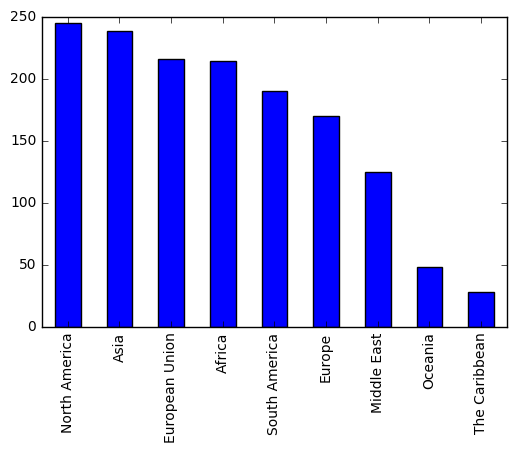

In [170]:
#speech_data['region'] = speech_data['country'].map(map_data.set_index('Country')['Region'])
pd.value_counts(speech_data['region']).plot.bar()

In [171]:
speech_data.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,region
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,Africa
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,Africa
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,Africa
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,Africa
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,Africa
38,41.0,5.0,"accra, ghana",akan1,akan,male,979,ghana,Africa
39,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,4,kosovo,Europe
40,33.0,15.0,"tirana, albania",albanian2,albanian,male,5,albania,Europe
41,44.0,35.0,"tirana, albania",albanian3,albanian,male,458,albania,Europe
42,33.0,28.0,"mitrovice, kosovo",albanian4,albanian,male,868,kosovo,Europe


### Now that we have properly mapped each region, lets get a label encoding for our classifier. Each unique region will be assigned a numerical mapping.

In [172]:
language_encoder = LabelEncoder()
language_encoder.fit(speech_data['region'])
speech_data['language_encoded'] = language_encoder.transform(speech_data['region'])
speech_data.head(10)

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,region,language_encoded
32,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,1,south africa,Africa,0
33,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,2,south africa,Africa,0
34,43.0,4.0,"pretoria, transvaal, south africa",afrikaans3,afrikaans,male,418,south africa,Africa,0
35,26.0,8.0,"pretoria, south africa",afrikaans4,afrikaans,male,1159,south africa,Africa,0
36,19.0,6.0,"cape town, south africa",afrikaans5,afrikaans,male,1432,south africa,Africa,0
38,41.0,5.0,"accra, ghana",akan1,akan,male,979,ghana,Africa,0
39,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,4,kosovo,Europe,2
40,33.0,15.0,"tirana, albania",albanian2,albanian,male,5,albania,Europe,2
41,44.0,35.0,"tirana, albania",albanian3,albanian,male,458,albania,Europe,2
42,33.0,28.0,"mitrovice, kosovo",albanian4,albanian,male,868,kosovo,Europe,2


### Although we have ~9 classes, we have found from our own tests that the accuracy improves 20% + from reducing the class size to 3. Lets take the 3 largest classes, Asia, North America and the EU. We will work with the all 9 categories later. We also remove the unneeded columns. We only need the filename, and encoded language from here on.

In [173]:
reg = ['North America','Asia','European Union']
speech_data = speech_data.loc[speech_data['region'].isin(reg)]
speech_data.drop('age', axis=1, inplace=True)
speech_data.drop('age_onset', axis=1, inplace=True)
speech_data.drop('birthplace', axis=1, inplace=True)
speech_data.drop('sex', axis=1, inplace=True)
speech_data.drop('country', axis=1, inplace=True)
speech_data.drop('region', axis=1, inplace=True)
speech_data.drop('native_language', axis=1, inplace=True)
speech_data.head(10)


,filename,speakerid,language_encoded
104,arabic38,1394,5
137,arabic68,1805,3
148,arabic78,1897,5
174,armenian3,849,1
176,armenian5,997,1
182,azerbaijani2,434,1
183,azerbaijani3,1791,1
197,basque2,33,3
199,bavarian2,1045,3
203,bengali1,34,1


### Now let's do some sound analysis. We will begin by exploring just one audio file.

In [174]:
filenames = speech_data.iloc[:, 0].get_values()             # We get the array of file names
filename = RECORDINGS + 'afrikaans4' + '.mp3'
Audio(filename)

### Load the mp3 file using librosa, and display the waveplot. Right now let's just explore the data of one file.

### We use the Librosa library because it offers easy compatibility with mp3 files, and easily lets just choose our own sampling rate and duration. The default sampling rate is 22.1kHz. We have tried to down sample to a 8kHz sampling rate but we lose too much data with this. 44.1kHz will increase our accuracy, but the time/memory trade off is not worth the trivial increase in accuracy. We will stick to the default sampling rate. 

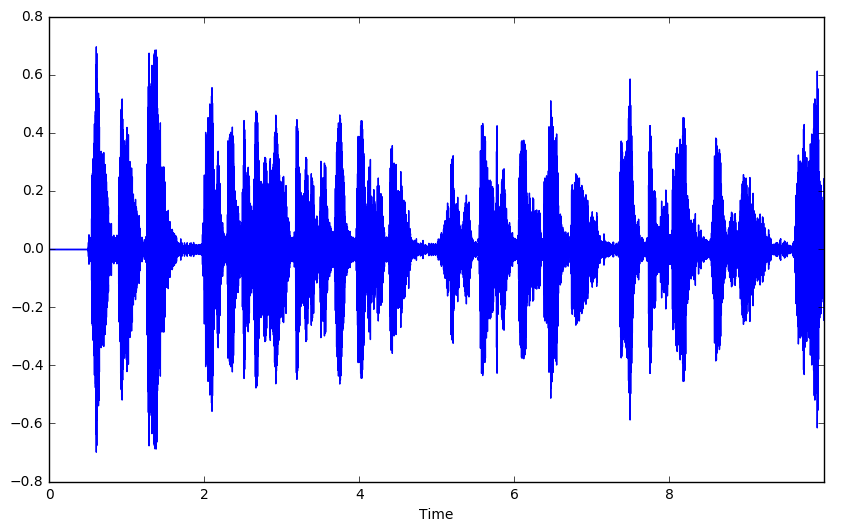

In [175]:
y, sr = librosa.load(filename, duration=10)     # y is the audio series and sr in the number of sample per second
plt.figure(figsize=(10,6))
librosa.display.waveplot(y, sr=sr)
plt.show()

### Plot how one individual sample looks like.

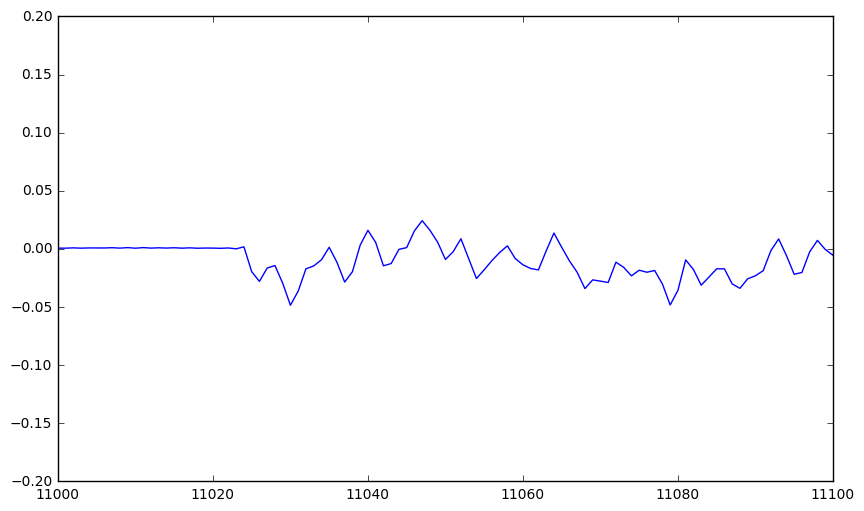

In [176]:
plt.figure(figsize=(10,6))                                # We then plot to see what each individual sample looks like
plt.plot(y,'b') 
plt.axis([11000,11100,-0.2,0.2])
plt.show()

### We will be performing a Fast Fourier Transformation on our audio files. With this, we must choose an appropriate window size and hop size. Longer windows give less temporal resolution and better coefficient quality; shorter windows give higher temporal resolution and lower coefficient quality.



In [156]:
_n_fft= int(sr * 0.030)
_hop_length= int(_n_fft - sr*0.015)   
print("Window Length: " , str(_n_fft))
print("Hop Length: " ,_hop_length)

Window Length:  661
Hop Length:  330


### Now let's perform the Fourier Transformation on the single audio file. Right now, our windows are rectangular, which has abrupt changes in the periodicity. We can apply a Hann window in order to smooth this out and reduce noise/coefficients. Since the number of frequency bins the FFT returns depends on the window size, we save the number of bins in this cell.

In [177]:
x = librosa.core.stft(y, n_fft=_n_fft, hop_length=_hop_length, window='hann')
num_bins = x.shape[0] + 20
n_bins = x.shape[0] + 20
x.shape

(331, 669)

### This is the Frequency domain of all our windows. Each color on the graph represents a different window.

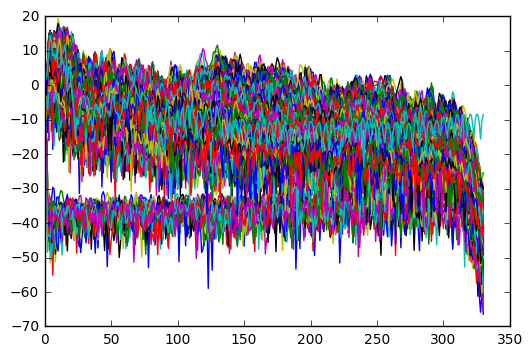

In [178]:
plt.plot(np.log10(abs(x))*10)
plt.show()

### This is our spectrogram produced from our Fourier Transformation. As you can see, this is a male speaker because the frequency is on the lower end of the spectrum

/home/sajid.kamal/anaconda3/lib/python3.5/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


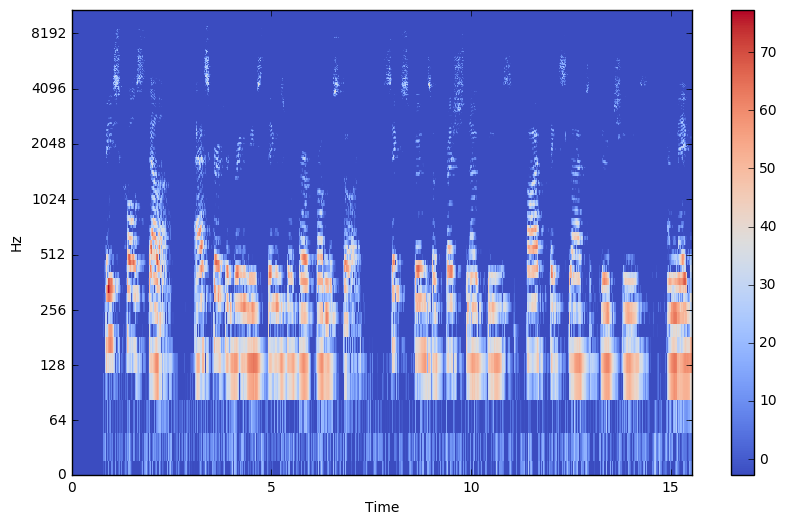

In [179]:
# Calculate log amplitude
example_stft_log_power = librosa.amplitude_to_db(x**2)

# Plot spectrogram
f, ax = plt.subplots(figsize=(10, 6))
librosa.display.specshow(example_stft_log_power, x_axis = 'time', y_axis = 'log')
plt.colorbar()

In [24]:
speech_data.shape

(700, 3)

### Now we start to process each individual file in our dataset. We load the first 10 seconds of the file( Any larger does not increase accuracy and significantly increases processing time and throttles our CPU/RAM). We apply the Fourier Transformation on each window the same way we did earlier. Librosa's STFT function splits our data into windows and applies the FTT to each window.  We also compute the MFCC of each window. At first, we only included the FTT data, but including MFCC features helped increase our accuracy. 

In [180]:
def fft_process(filename, language_encoding):
    y, sr = librosa.load(RECORDINGS + filename + FILE_EXTENSION, duration=10)
    ## transpose the stft so we have frequency bins as columns, windows as rows
    x = librosa.core.stft(y, n_fft=_n_fft, hop_length=_hop_length,window='hann')
    x = abs(x).T
    mfcc = librosa.feature.mfcc(y=y, sr=sr,n_fft=_n_fft, hop_length=_hop_length, n_mfcc=20).T
    x = np.hstack((x,mfcc))
    label_vector = np.full((x.shape[0], 1), language_encoding, dtype=int)
    return x, label_vector

### Processing each file individually sequentially took a long time.

In [ ]:
# %%time
# freq_bins_matrix = np.array([]).reshape(0,n_bins)
# label_vector = np.array([]).reshape(0,1)

# print("Original fbm: ", freq_bins_matrix.shape)
# print("Original lb: ", label_vector.shape)

# for index, row in speech_data.head(200).iterrows():
#     if os.path.exists(RECORDINGS + row['filename']+ FILE_EXTENSION):
#         bins_data , l_vector = fft_process(row['filename'],row['language_encoded'])
#         freq_bins_matrix = np.concatenate((freq_bins_matrix, bins_data))
#         label_vector = np.concatenate((label_vector, l_vector))
#         print(index)
# #         if(index % 8 == 0):
# #         print(row)

# print(label_vector.shape)

### Since we ran our Notebook on a Google Cloud Computational Server with 8 vCPU's and 52GB of RAM, we decided to use all of the machine's computing power. We did much of the processing concurrently with multiple threads and this reduced the processing time by over 50%.

In [181]:
%%time 
all_freq_bins_matrix = np.array([]).reshape(0,n_bins)
all_label_vector = np.array([]).reshape(0,1)

print("Original a_fbm: ", all_freq_bins_matrix.shape)
print("Original a_lv: ", all_label_vector.shape)

# import threads
from threading import Lock
fbm_mutex = Lock()
lv_mutex = Lock()

# create thread safe concatenation functions
def fbm_thread_safe_concat(bins_data):
    fbm_mutex.acquire(blocking=True, timeout=-1)
    try:
        global all_freq_bins_matrix
        all_freq_bins_matrix = np.concatenate((all_freq_bins_matrix, bins_data))
    finally:
        fbm_mutex.release()

def lv_thread_safe_concat(l_vector):
    lv_mutex.acquire(blocking=True, timeout=-1)
    try:
        global all_label_vector
        all_label_vector = np.concatenate((all_label_vector, l_vector))
    finally:
        lv_mutex.release()
    
# define function to be mapped
def bucci_loop(x):
    if(x>=speech_data.shape[0]):
        return x
    global speech_data, RECORDINGS, FILE_EXTENSION
    row = speech_data.iloc[x, :]
    if os.path.exists(RECORDINGS + row['filename']+ FILE_EXTENSION):
        bins_data , l_vector = fft_process(row['filename'],row['language_encoded'])
        fbm_thread_safe_concat(bins_data)
        lv_thread_safe_concat(l_vector)
        print(x)
    return x

# spawn threads and run look
from multiprocessing.dummy import Pool as ThreadPool 
N_THREADS = 16
pool = ThreadPool(N_THREADS) 
i = 0
while i <= speech_data.shape[0]:
    results = pool.map(bucci_loop, range(i,i+N_THREADS))
    i+=N_THREADS
    print (i)
    
print(all_label_vector.shape)

Original a_fbm:  (0, 351)
Original a_lv:  (0, 1)
14
10
8
13
1
9
6
4
15
3
5
12
11
2
7
0
16
27
24
1916

18
29
30
28
21
22
25
26
17
20
23
31
32
32
33
37
42
35
43
36
41
39
34
47
38
44
45
46
40
48
63
60
50
55
48
61
59
58
52
54
56
51
53
49
62
57
64
70
78
72
65
76
68
66
73
79
64
74
67
77
69
71
75
80
90
82
86
80
87
89
81
88
93
83
85
94
84
91
92
95
96
103
108
104
100
97
111
105
99
109
102
96
106
101
107
98
110
112
113
123
124
119
118
112
120
125
121
127
116
126
115
117
122
114
128
136
132
128
140
142
138
139
131
133
129
135
143
141
130
134
137
144
149
154
153
157
151
145
155
148
152
156
159
158
150
147
146
144
160
167
174
171
175
163
162
165
168
164
166
161
170
169
173
172
160
176
184
185
177
180
179
182
178
191
181
176
187
188
190
189
183
186
192
199
204
197
193
194
201
195
203
196
206
200
198
205
192
207
202
208
222
214
221
219
223
211
217
212
209
220
210
216
208
218
215
213
224
224
231
235
236
239
234
238
233
229
225
230
226
227
237
228
232
240
251
245
244
248
242
240
255
247
252
253
243
241

In [182]:
all_freq_bins_matrix.shape

(267600, 351)

In [183]:
all_freq_bins_matrix.shape

(267600, 351)

### Define functions to plot confusion matrix to help us better describe the performance of the classification model

In [184]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def show_confusion_matrix(y_test, y_pred, class_names):    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    plt.figure(figsize=(13,9))
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure(figsize=(13,9))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

### Now that we processed all our data, we will use a Multi-Layer Perception Nueral Network to classify our data. 

In [190]:
%%time 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import itertools
class_names = ["1", "2",'3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '14']
labels = all_label_vector.T.reshape(-1)
features = all_freq_bins_matrix
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=0)
n= int((X_train.shape[0])/(2*(X_train.shape[1] + 3)))
classifier = MLPClassifier(verbose=10, hidden_layer_sizes=(n,))
# X_train = features[0:(669*490)]
# y_train = labels[0:(669*490)]

# X_test = features[-(669*210):]
# y_test = labels[-(669*210):]

classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
predicted_prob = np.array(classifier.predict_proba(X_test))


Iteration 1, loss = 1.16624262
Iteration 2, loss = 0.90181659
Iteration 3, loss = 0.88012047
Iteration 4, loss = 0.84600865
Iteration 5, loss = 0.82890230
Iteration 6, loss = 0.81022012
Iteration 7, loss = 0.79920768
Iteration 8, loss = 0.78662531
Iteration 9, loss = 0.77333006
Iteration 10, loss = 0.76212540
Iteration 11, loss = 0.75611823
Iteration 12, loss = 0.74121874
Iteration 13, loss = 0.73205597
Iteration 14, loss = 0.73072239
Iteration 15, loss = 0.71647666
Iteration 16, loss = 0.70976485
Iteration 17, loss = 0.70222127
Iteration 18, loss = 0.69740861
Iteration 19, loss = 0.68871807
Iteration 20, loss = 0.68068839
Iteration 21, loss = 0.67913974
Iteration 22, loss = 0.67160003
Iteration 23, loss = 0.66604132
Iteration 24, loss = 0.66192725
Iteration 25, loss = 0.65604250
Iteration 26, loss = 0.65393473
Iteration 27, loss = 0.64795726
Iteration 28, loss = 0.64515445
Iteration 29, loss = 0.64102752
Iteration 30, loss = 0.63745068
Iteration 31, loss = 0.63438720
Iteration 32, los

In [191]:
from sklearn.metrics import accuracy_score, classification_report


### Let's look at the metrics for our model. First compute the accuracy of our model. We achieved >70% accuracy

In [192]:
accuracy_score(y_test, y_pred)

0.7049775784753364

### Calculate Loss metrics

In [201]:
print("Loss: ", classifier.loss_)
print("Log Loss: ", log_loss(y_test, predicted_prob))

Loss:  0.5392294760590699
Log Loss:  0.7494833646217489


In [194]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        1.0       0.52      0.43      0.47      7159
        3.0       0.66      0.50      0.57     19842
        5.0       0.74      0.86      0.79     39899

avg / total       0.70      0.70      0.69     66900



### Calculate Confusion Matrix

Confusion matrix, without normalization
[[ 3100  1004  3055]
 [ 1116  9942  8784]
 [ 1773  4005 34121]]
Normalized confusion matrix
[[0.43 0.14 0.43]
 [0.06 0.5  0.44]
 [0.04 0.1  0.86]]


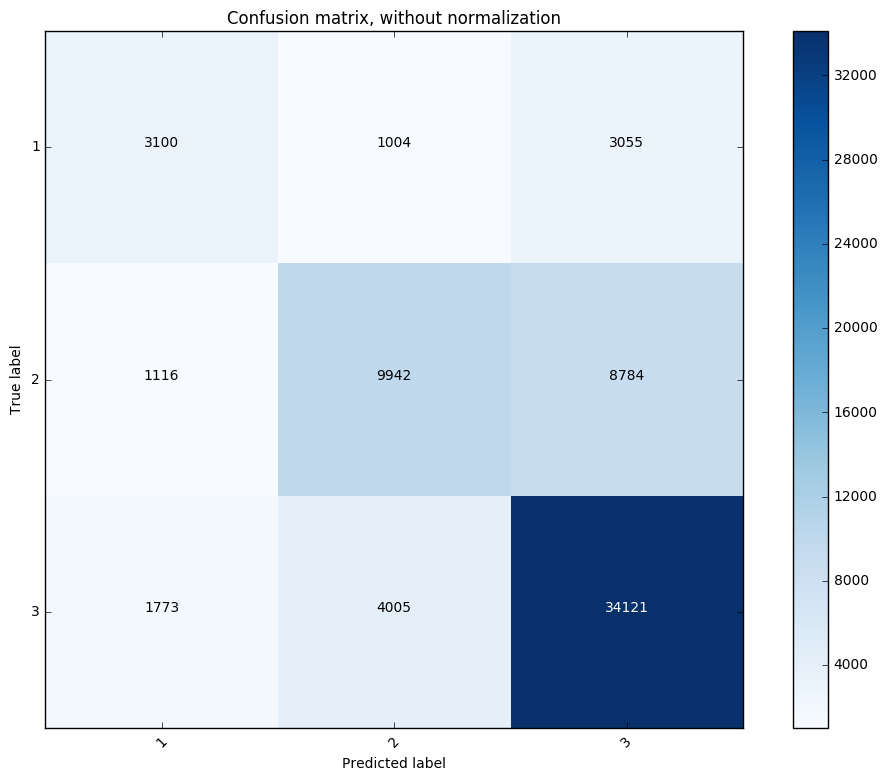

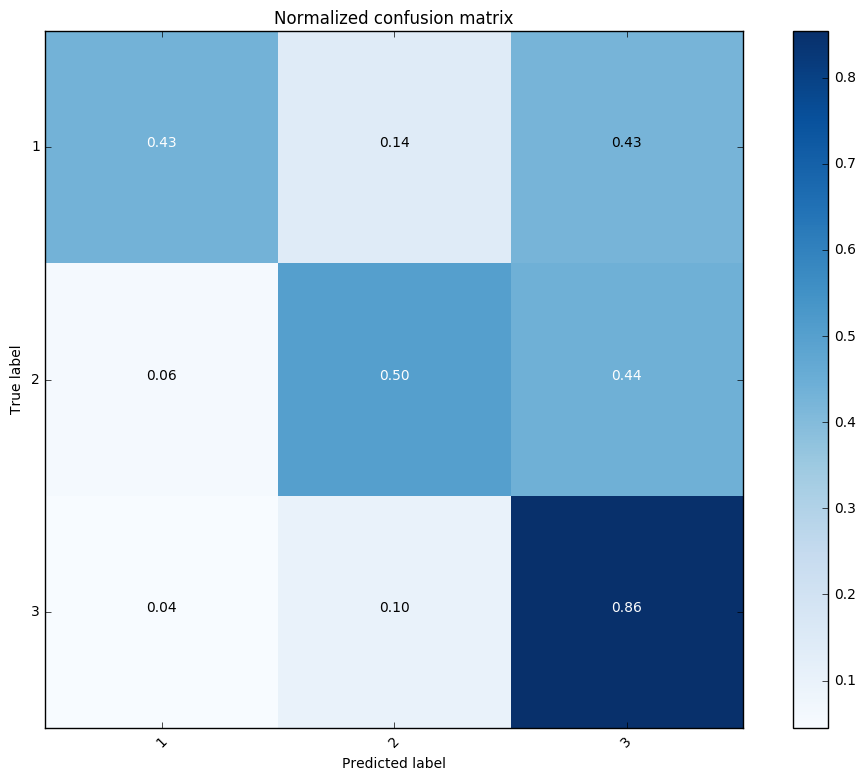

In [202]:
class_names = ["1", "2",'3']
show_confusion_matrix(y_test, y_pred, class_names)

### Use pandas_ml to calculate other metrics such as FDR, False Positive/Negative, F1 score, etc

In [203]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix(y_test, y_pred)
cm.print_stats()

Confusion Matrix:

Predicted   1.0    3.0    5.0  __all__
Actual                                
1.0        3100   1004   3055     7159
3.0        1116   9942   8784    19842
5.0        1773   4005  34121    39899
__all__    5989  14951  45960    66900


Overall Statistics:

Accuracy: 0.7049775784753364
95% CI: (0.7015054547943043, 0.7084319157287828)
No Information Rate: ToDo
P-Value [Acc > NIR]: 3.4032237145517735e-24
Kappa: 0.4264889796219101
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                      1.0       3.0       5.0
Population                                 66900     66900     66900
P: Condition positive                       7159     19842     39899
N: Condition negative                      59741     47058     27001
Test outcome positive                       5989     14951     45960
Test outcome negative                      60911     51949     20940
TP: True Positive                           3100      9942     34121
TN: True Negative

In [ ]:
### Lets test it on a file. We will use a file that was not used in our training or test data.

In [246]:
speech_data[speech_data['filename']=='english20']

,filename,speakerid,language_encoded


### Now let's process the file and pass it into our classfier. As you can see, the majority of the outputs are 5, which is encoded to North America. 76% of the labels are North America. Since we are taking the output with the highest number of occurence (winner takes all), this is the expected output.

In [247]:
test_file_matrix, test_file_labels = fft_process('english20', 5)
arr = classifier.predict(test_file_matrix)
len(arr[arr==5])/len(arr)

0.7668161434977578

In [248]:
test_file_matrix, test_file_labels = fft_process('cantonese4', 1)
arr = classifier.predict(test_file_matrix)
len(arr[arr==1])/len(arr)

0.8400597907324364